In [1]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import IPython
import librosa
import librosa.display
from tqdm.autonotebook import tqdm

/home/AD/tsainbur/anaconda3/envs/cdcp_paper_37/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [264]:
def save_fig(
    loc, dpi=300, save_pdf=False, save_svg=False, save_png=False, save_jpg=True
):
    if save_pdf:
        plt.savefig(str(loc) + ".pdf", dpi=dpi, bbox_inches="tight", pad_inches=0)
    if save_svg:
        plt.savefig(
            str(loc) + ".svg",
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0,
            transparent=True,
        )
    if save_png:
        plt.savefig(
            str(loc) + ".png",
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0,
            transparent=True,
        )
    if save_jpg:
        plt.savefig(
            str(loc) + ".jpg", dpi=int(dpi / 2), bbox_inches="tight", pad_inches=0
        )

In [3]:
import pickle

In [12]:
crepe_pitch = np.load('crepe_pitch2.npy', allow_pickle=True)
macaque_distance_matrix = np.load('macaque_distance_matrix.numpy.npy', allow_pickle=True)
indvs = np.load('indv.npy', allow_pickle=True)
specs = np.load('specs.npy', allow_pickle=True)

In [261]:
MDS_projection_dtw = np.load('MDS_projection.numpy.npy', allow_pickle=True)

In [19]:
import seaborn as sns
import umap

In [16]:
cat = indvs
pal = {i:j for i, j in zip(np.unique(cat), sns.color_palette('Set1', len(np.unique(cat))))}
cols = [pal[i] for i in cat]

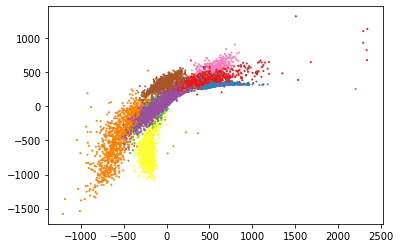

In [17]:
plt.scatter(MDS_projection[:,0], MDS_projection[:,1], c = cols, s=1)

In [21]:
umap_projections = umap.UMAP(verbose=True, metric = 'precomputed').fit_transform(macaque_distance_matrix)

/mnt/cube/tsainbur/Projects/github_repos/umap/umap/umap_.py:1758: UserWarning: using precomputed metric; inverse_transform will be unavailable
  "using precomputed metric; inverse_transform will be unavailable"


UMAP(metric='precomputed', verbose=True)
Construct fuzzy simplicial set
Fri Jul 23 11:31:53 2021 Finding Nearest Neighbors
Fri Jul 23 11:31:56 2021 Finished Nearest Neighbor Search
Fri Jul 23 11:32:00 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Jul 23 11:32:19 2021 Finished embedding


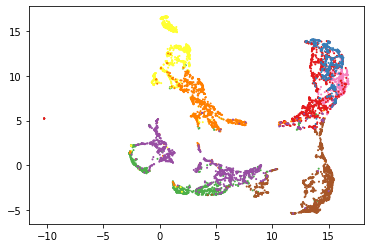

In [22]:
plt.scatter(umap_projections[:,0], umap_projections[:,1], c = cols, s=1)

In [198]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
from PIL import Image 
def log_resize_spec(spec, spec_len_mul=15, freq_bins = 64):
    resize_shape = [int(np.log(np.shape(spec)[1])*spec_len_mul), freq_bins]
    resize_spec = np.array(Image.fromarray(spec).resize(resize_shape, Image.ANTIALIAS))
    return resize_spec


In [199]:
def pad_spectrogram(spectrogram, pad_length):
    """ Pads a spectrogram to being a certain length
    """
    excess_needed = pad_length - np.shape(spectrogram)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        spectrogram, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

In [200]:
#specs = [i[:40,:] for i in tqdm(specs)]

In [223]:
specs = np.load('specs.npy', allow_pickle=True)

In [224]:
specs[0].shape

(257, 206)

In [225]:
sr = 22050

In [226]:
mel_specs = [librosa.feature.melspectrogram(S=i, sr=sr) for i in tqdm(specs)]
mel_specs = [i[:128] for i in mel_specs]

  0%|          | 0/7285 [00:00<?, ?it/s]

In [227]:
mel_specs[0].shape

(128, 206)

In [228]:
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [229]:
with Parallel(n_jobs=1, verbose=verbosity) as parallel:
    specs_resized = parallel(
        delayed(log_resize_spec)(spec)
        for spec in tqdm(
            mel_specs
        )
    )

  0%|          | 0/7285 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7285 out of 7285 | elapsed:    3.7s finished


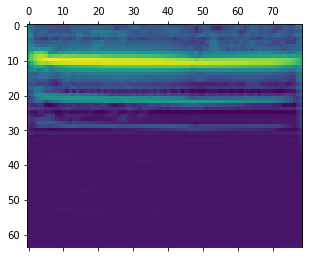

In [230]:
plt.matshow(specs_resized[0])

In [231]:
specs_resized[0].shape

(64, 79)

In [232]:
specs_resized_norm = [norm(i) for i in tqdm(specs_resized)]
spec_lens = [i.shape[1] for i in specs_resized_norm]

  0%|          | 0/7285 [00:00<?, ?it/s]

In [233]:
with Parallel(n_jobs=1, verbose=verbosity) as parallel:
    specs_padded = parallel(
        delayed(pad_spectrogram)(spec, np.max(spec_lens))
        for spec in tqdm(
            specs_resized_norm
        )
    )

  0%|          | 0/7285 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7285 out of 7285 | elapsed:    4.1s finished


In [234]:
specs_padded = np.array(specs_padded)
specs_padded.shape

(7285, 64, 105)

(-0.5, 104.5, -0.5, 63.5)

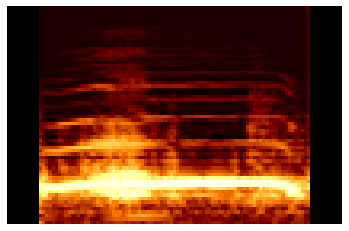

In [281]:
fig, ax = plt.subplots()
ax.matshow(specs_padded[4000], origin = 'lower', aspect='auto', cmap = plt.cm.afmhot)
ax.axis('off')

In [236]:
def plot_voc_canvas(specs_padded, nrow = 6, ncol = 20, zoom = 2):
    """
    """
    dimx = np.shape(specs_padded[0])[0]
    dimy = np.shape(specs_padded[0])[1]

    canvas = np.zeros((nrow*dimx, ncol*dimy))
    cn = 0
    for row in range(nrow)[::-1]:
        for col in range(ncol):
            canvas[dimx*row:dimx*(row+1), dimy*col:dimy*(col+1)] = specs_padded[cn]
            cn += 1

    fig, ax = plt.subplots(figsize=(ncol*zoom*2, nrow*zoom))
    ax.matshow(canvas, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    ax.axis('off')
    plt.show()

In [237]:
specs_padded.shape

(7285, 64, 105)

In [285]:
np.save('specs_padded', specs_padded)

AL


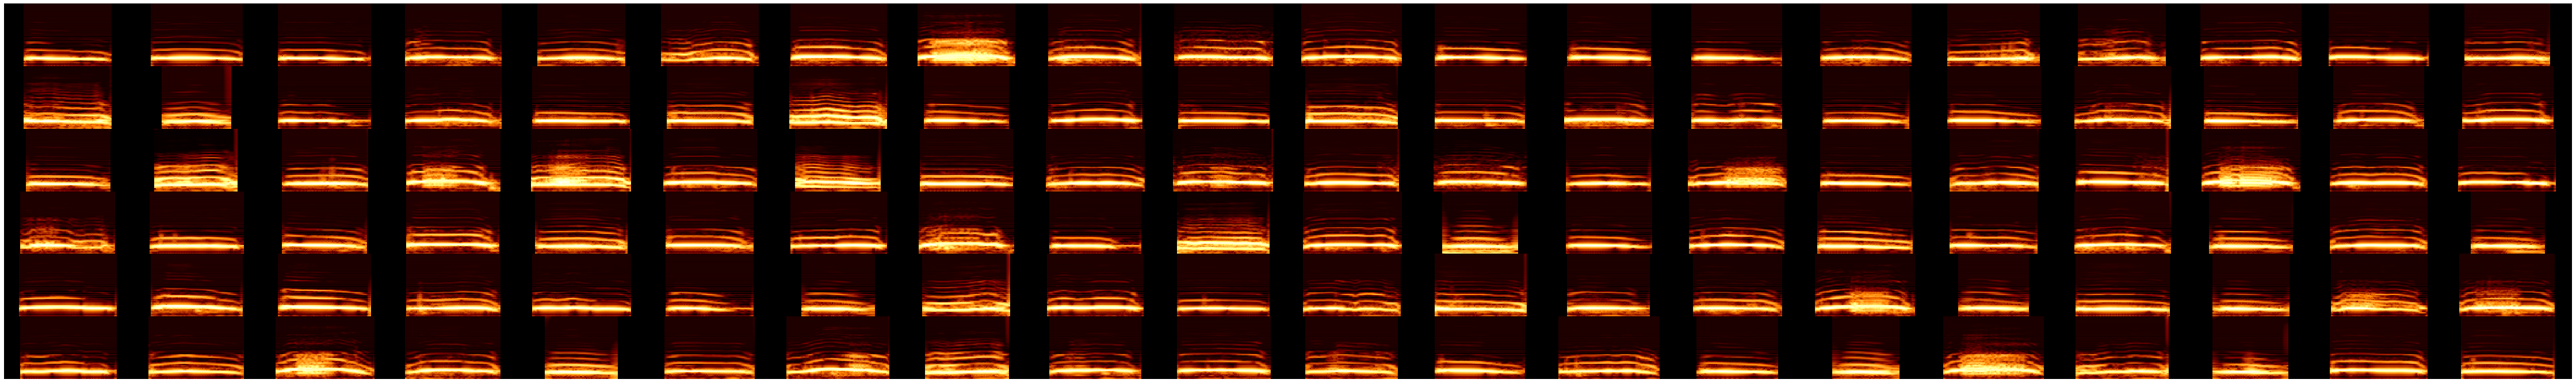

BE


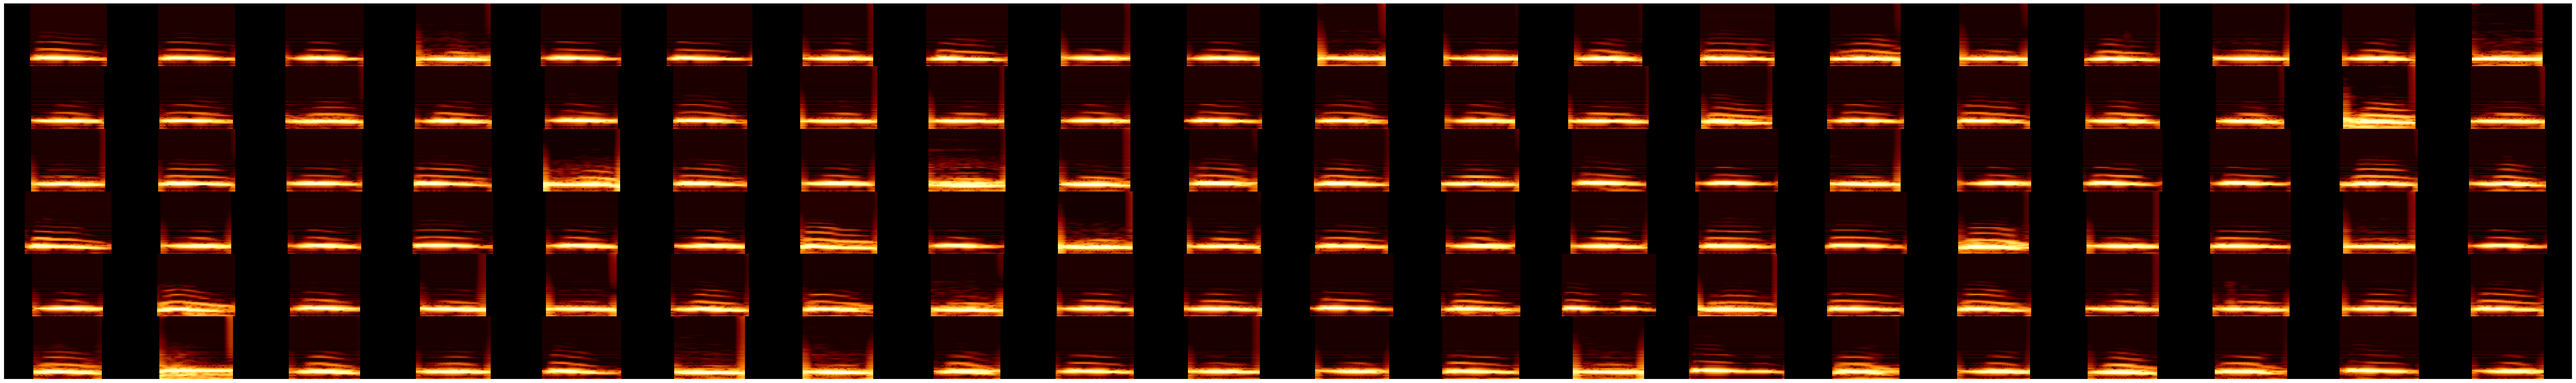

IO


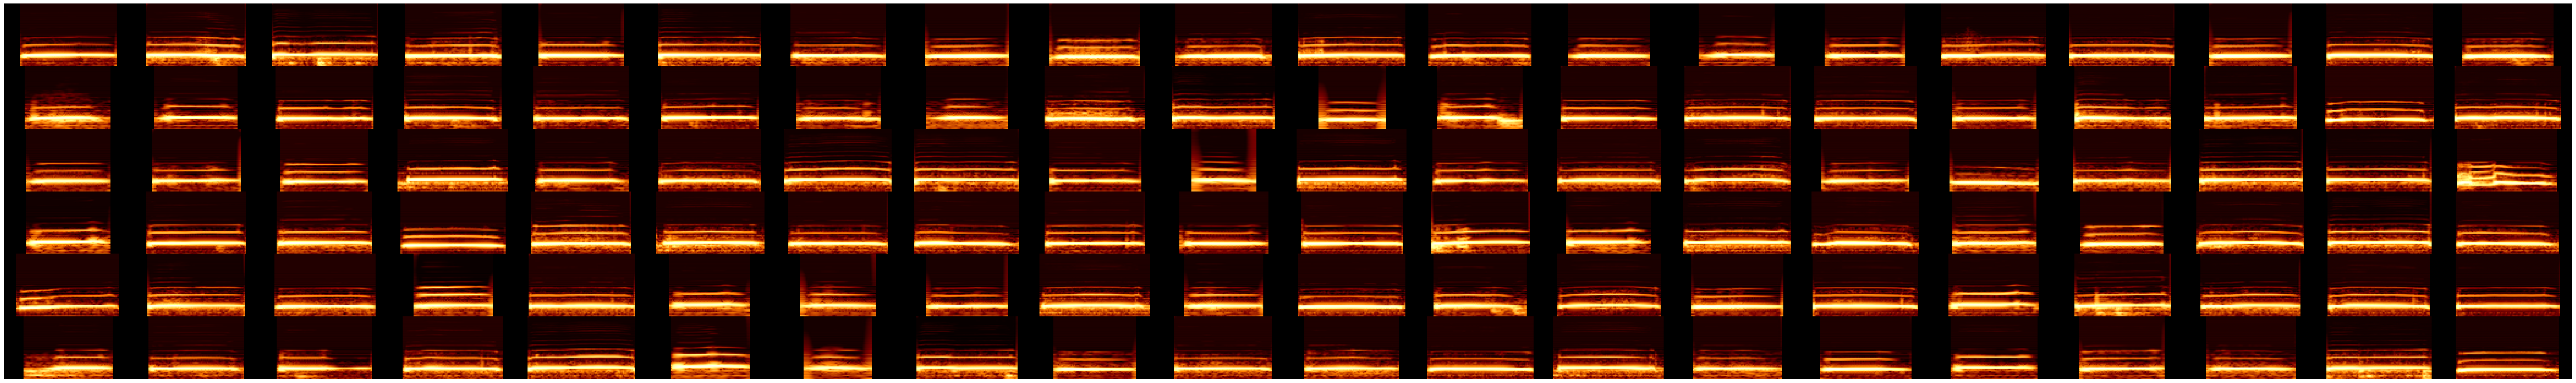

MU


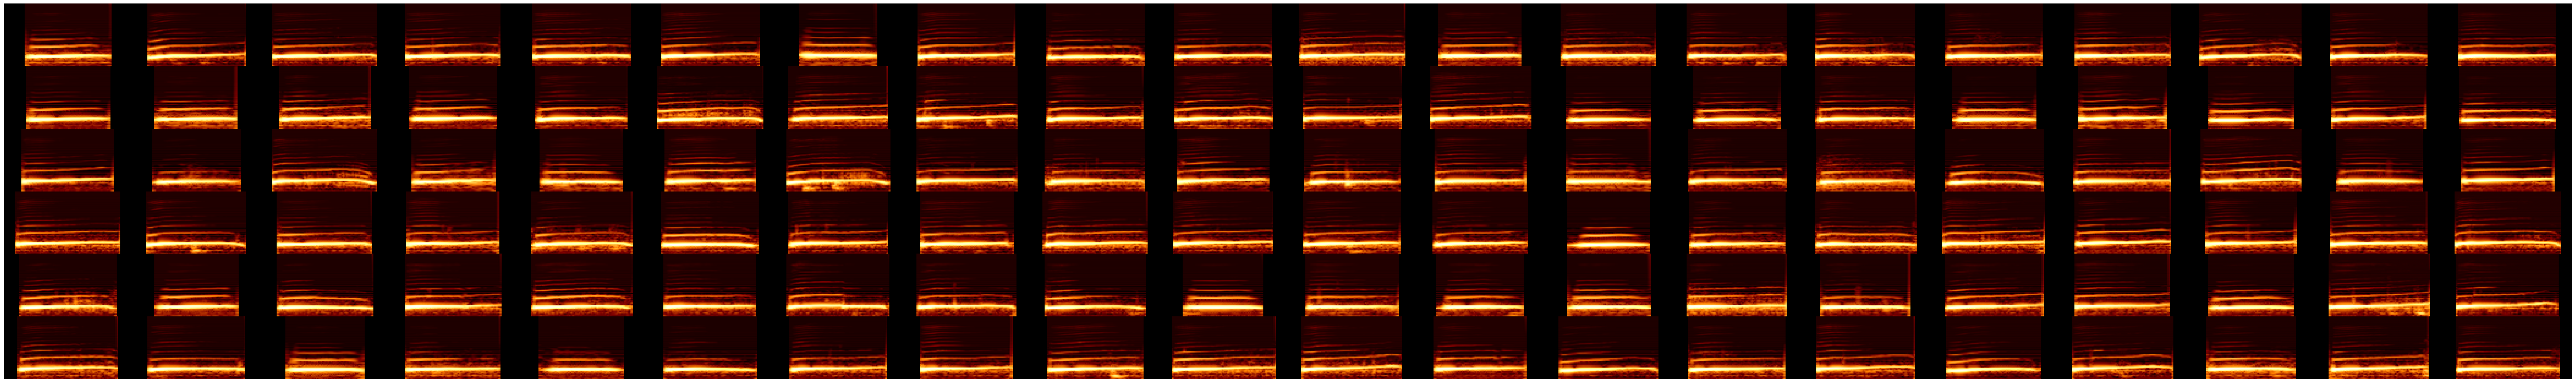

QU


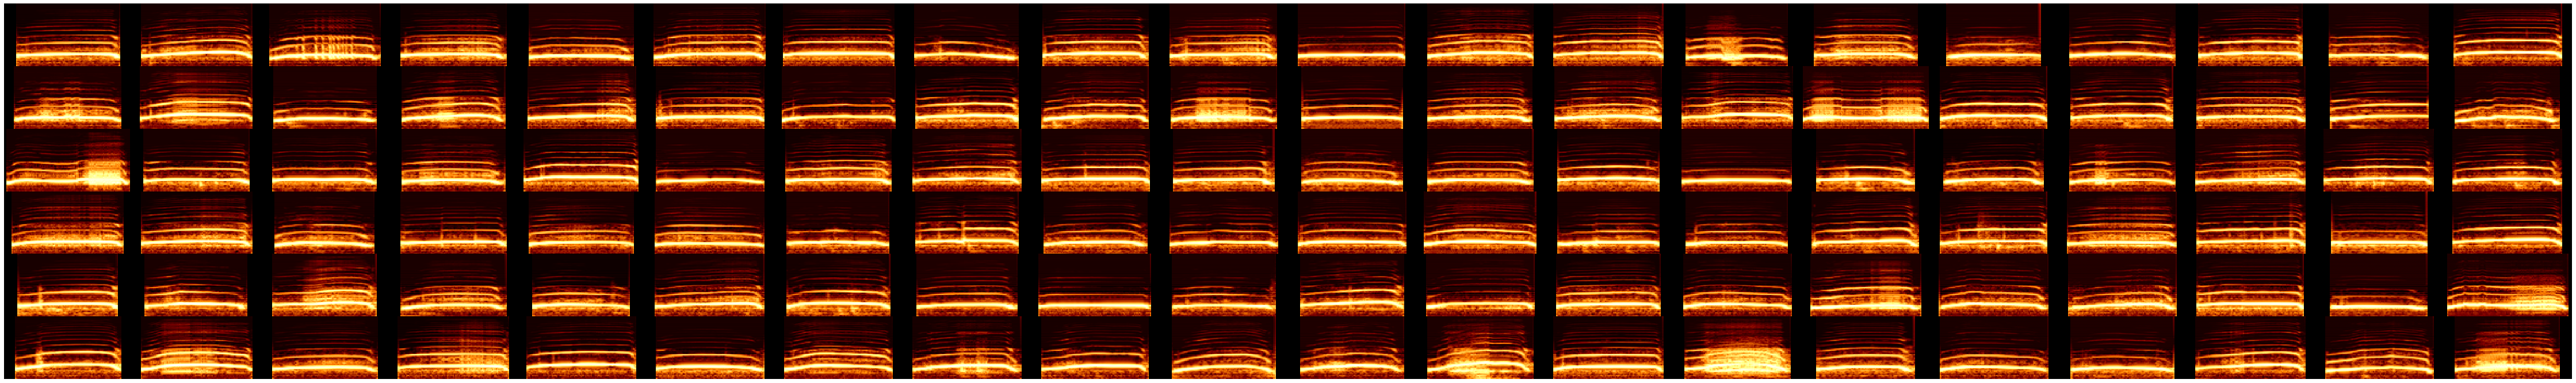

SN


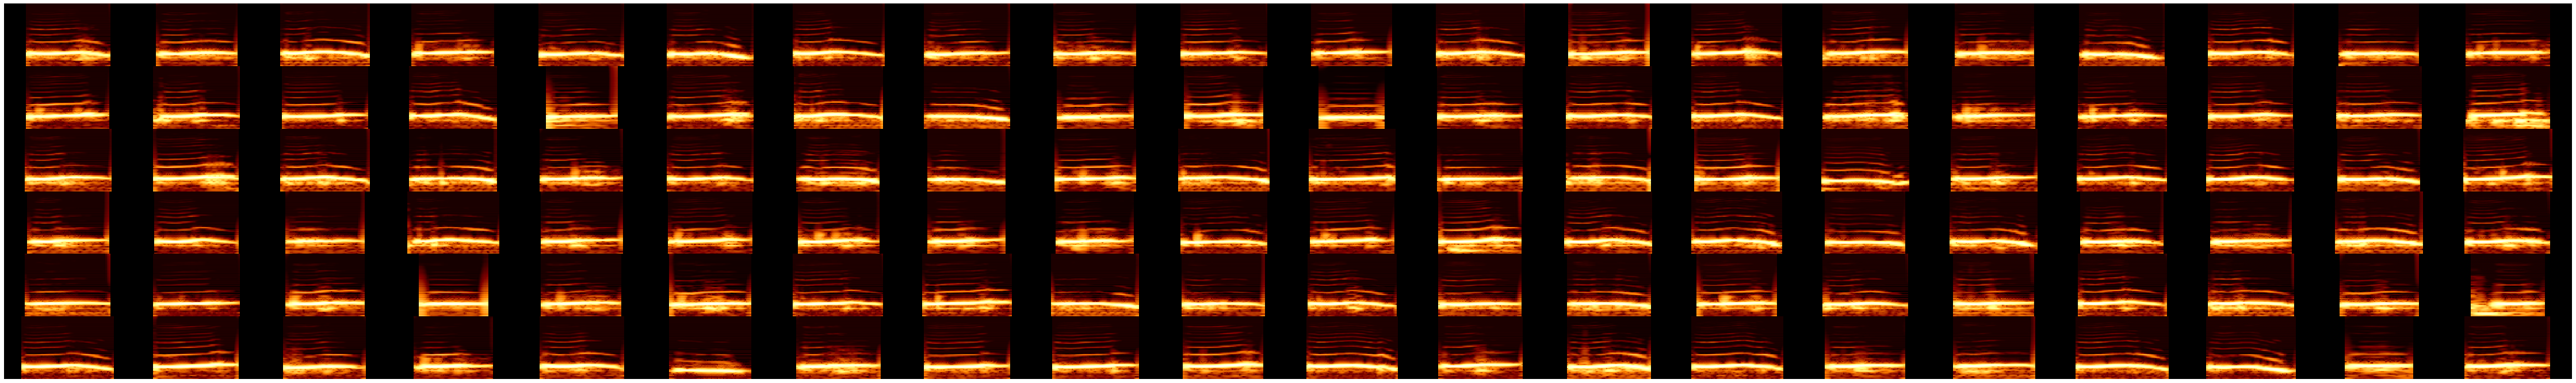

TH


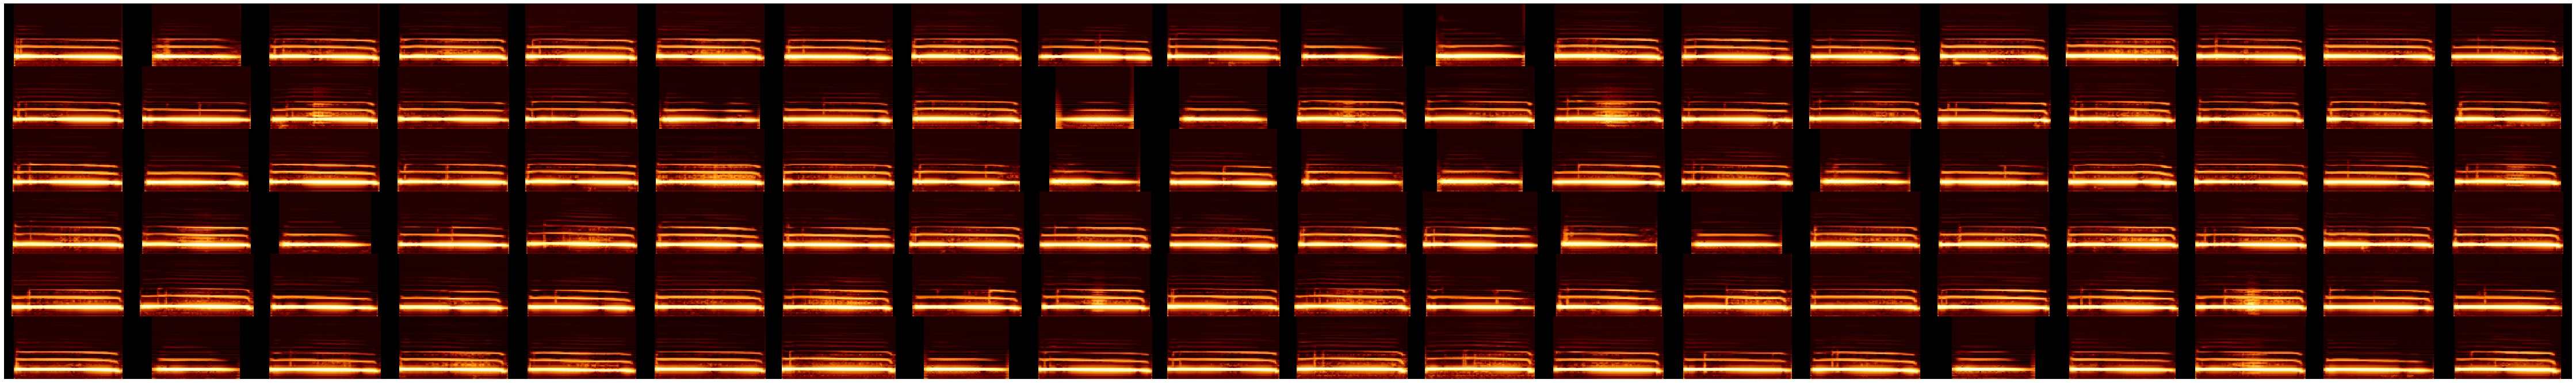

TW


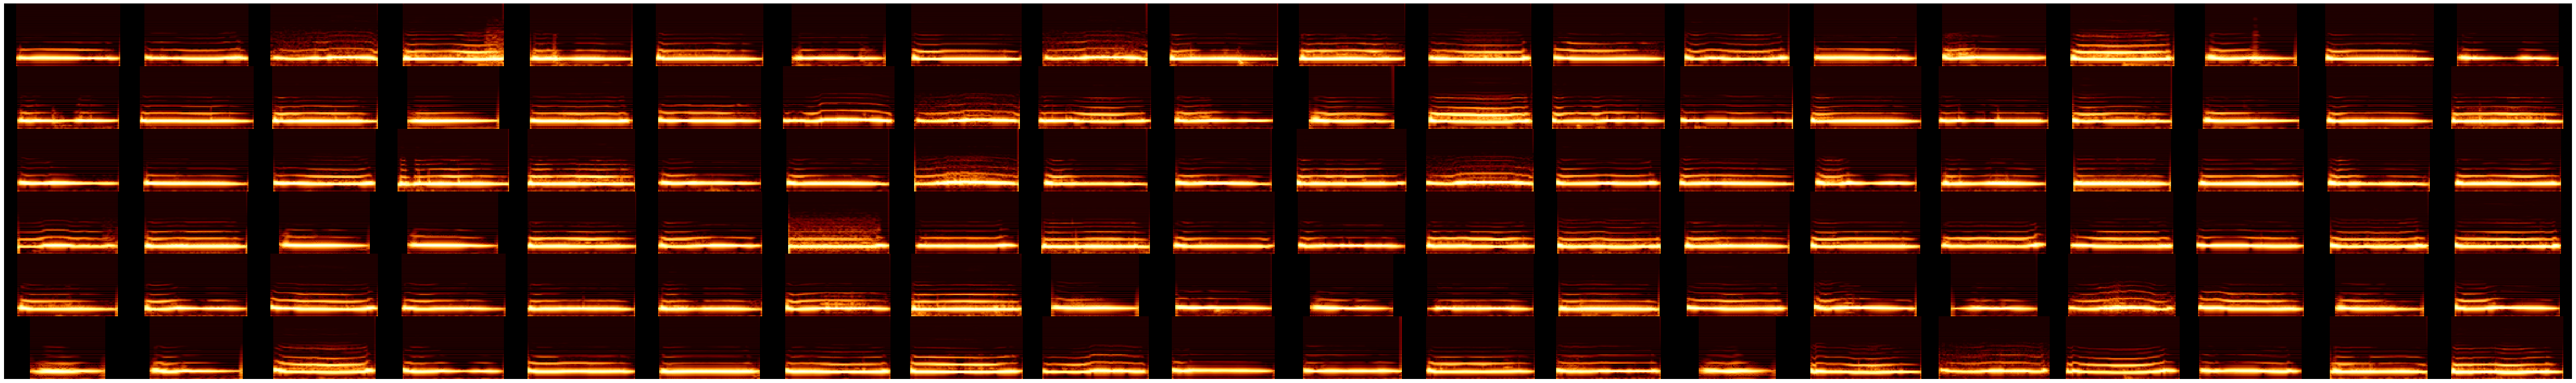

In [238]:
for indv in np.unique(indvs):
    
    print(indv)
    plot_voc_canvas(specs_padded[
        (indvs == indv)
    ])

In [239]:
import umap
import seaborn as sns

In [240]:
specs = np.stack(specs_padded, axis=2).T
specs_flattened = np.reshape(specs, (np.shape(specs)[0], np.prod(np.shape(specs)[1:])))
len(specs_flattened)

7285

In [241]:
np.shape(specs_flattened)

(7285, 6720)

In [242]:
spec_umap = umap.UMAP(verbose=True).fit_transform(specs_flattened)

UMAP(verbose=True)
Construct fuzzy simplicial set
Fri Jul 23 11:53:29 2021 Finding Nearest Neighbors
Fri Jul 23 11:53:29 2021 Building RP forest with 9 trees
Fri Jul 23 11:53:29 2021 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Fri Jul 23 11:53:30 2021 Finished Nearest Neighbor Search
Fri Jul 23 11:53:30 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Jul 23 11:53:42 2021 Finished embedding


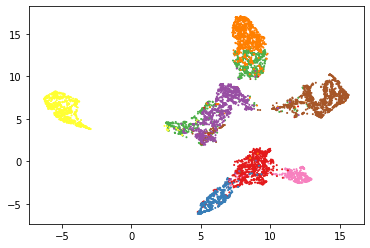

In [243]:
plt.scatter(spec_umap[:,0], spec_umap[:,1], c = cols, s=1)

In [245]:
from sklearn.manifold import MDS

In [246]:
specs_flattened.shape

(7285, 6720)

In [284]:
np.save('specs_flattened', specs_flattened)

In [249]:
MDS_projection = MDS(n_jobs=1, verbose=20, n_init = 1)
MDS_projection_z = MDS_projection.fit_transform(specs_flattened)

it: 0, stress 4177808771.0166283
it: 1, stress 934006830.1605476
it: 2, stress 877587546.6420851
it: 3, stress 841015857.2984469
it: 4, stress 817115944.4007812
it: 5, stress 800733740.3207223
it: 6, stress 788854776.4748199
it: 7, stress 780016147.5193474
it: 8, stress 773371824.5736952
it: 9, stress 768340227.4681549
it: 10, stress 764490235.78133
it: 11, stress 761509265.6463343
it: 12, stress 759146739.9527043
it: 13, stress 757284515.6429784
it: 14, stress 755858984.8275706
it: 15, stress 754751021.4608892
it: 16, stress 753871337.6638751
it: 17, stress 753155918.4423611
it: 18, stress 752553696.9961618
it: 19, stress 752023277.8774887
it: 20, stress 751532482.9073179
it: 21, stress 751055777.9448563
it: 22, stress 750571375.6354027
it: 23, stress 750061051.1323717
it: 24, stress 749507391.294504
it: 25, stress 748894812.792773
it: 26, stress 748206591.5025736
it: 27, stress 747425473.549724
it: 28, stress 746533101.5098555
it: 29, stress 745509240.7463901
it: 30, stress 744330801

it: 243, stress 306065477.16283303
it: 244, stress 306036333.55922383
it: 245, stress 306006257.15374947
it: 246, stress 305975148.92862916
it: 247, stress 305943531.0750543
it: 248, stress 305911466.36200666
it: 249, stress 305879096.3755228
it: 250, stress 305846714.8260535
it: 251, stress 305814888.9906976
it: 252, stress 305784341.22203773
it: 253, stress 305755478.9125551
it: 254, stress 305727727.7376795
it: 255, stress 305699935.67783505
it: 256, stress 305671581.3360834
it: 257, stress 305643265.8732604
it: 258, stress 305616668.8317623
it: 259, stress 305593851.5991236
it: 260, stress 305575270.3301745
it: 261, stress 305560001.05052817
it: 262, stress 305546742.94858235
it: 263, stress 305534544.1974356
it: 264, stress 305522948.76180667
it: 265, stress 305511674.88987094
it: 266, stress 305500574.1274991
it: 267, stress 305489497.86276287
it: 268, stress 305478263.2900432
it: 269, stress 305466648.1262939
it: 270, stress 305454444.2293412
it: 271, stress 305441373.59327453
i

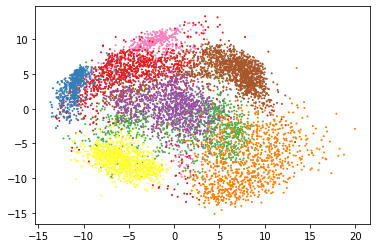

In [251]:
plt.scatter(MDS_projection_z[:,0], MDS_projection_z[:,1], c = cols, s=1)

In [252]:
from projections import scatter_spec

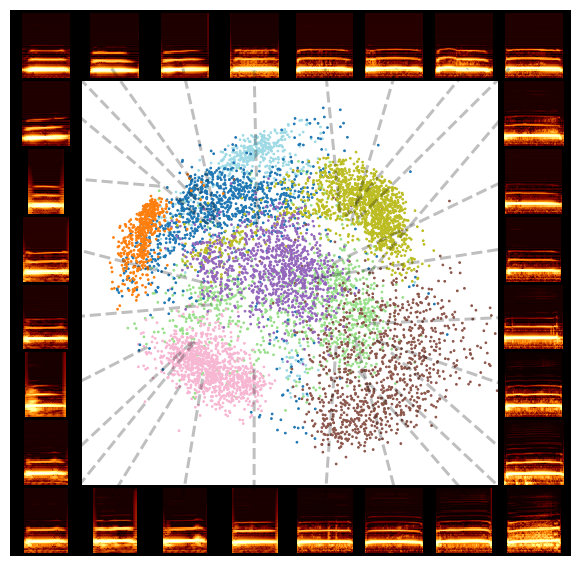

In [268]:
nex = -1
scatter_spec(
    MDS_projection_z[:nex],
    specs_padded[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': indvs[:nex],
        'alpha':1,
        's': 3,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.afmhot
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(Path('../figures') / 'MDS_spec', dpi=300, save_jpg=True, save_png=True)

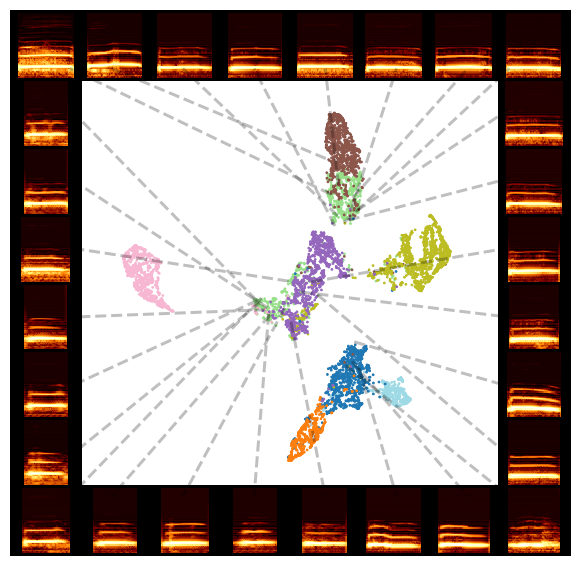

In [269]:
nex = -1
scatter_spec(
    spec_umap[:nex],
    specs_padded[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': indvs[:nex],
        'alpha':1,
        's': 3,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.afmhot
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(Path('../figures') / 'umap_spec', dpi=300, save_jpg=True, save_png=True)

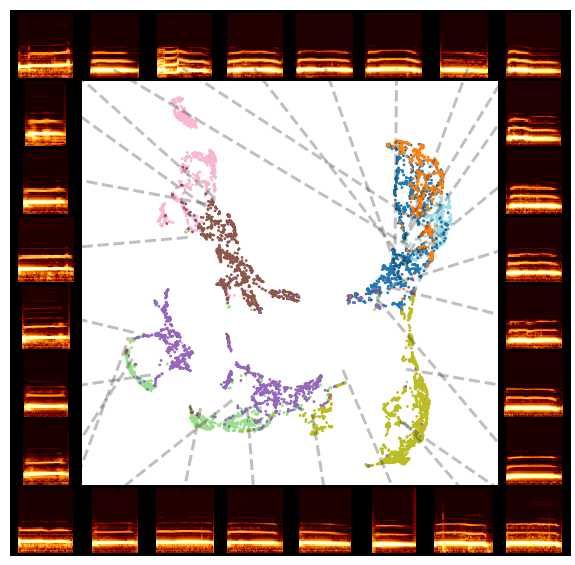

In [267]:
nex = -1
scatter_spec(
    umap_projections[:nex],
    specs_padded[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': indvs[:nex],
        'alpha':1,
        's': 3,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.afmhot
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(Path('../figures') / 'umap_dtw', dpi=300, save_jpg=True, save_png=True)

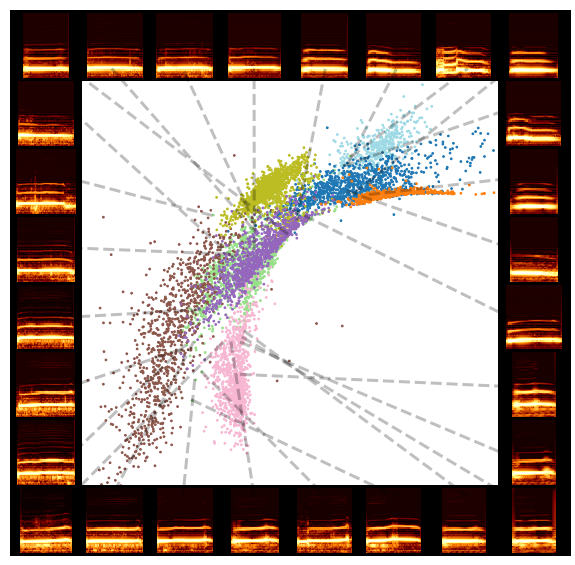

In [265]:
nex = -1
scatter_spec(
    MDS_projection_dtw[:nex],
    specs_padded[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': indvs[:nex],
        'alpha':1,
        's': 3,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.afmhot
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(Path('../figures') / 'MDS_dtw', dpi=300, save_jpg=True, save_png=True)

In [283]:
import trimap

ModuleNotFoundError: No module named 'trimap'

In [ ]:
embedding_trimap = trimap.TRIMAP(verbose=True).fit_transform(specs_flattened)